In [1]:
import sys
from pathlib import Path
import os

root_dir = Path.cwd().parent   # ← one directory up
root_dir = str(root_dir)
print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Set the environment variables from the file <root_dir>/.env
import config
if os.path.exists(f"{root_dir}/.env"):
    settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")


Local environment
Added the following directory to the PYTHONPATH: /Users/annastegaras/Desktop/ID2223/project/ML_Scale_Project
HopsworksSettings initialized!


In [2]:
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks

import warnings
warnings.filterwarnings("ignore")

#### Some comments 

In [3]:
# Check if HOPSWORKS_API_KEY env variable is set or if it is set in ~/.env
if settings.HOPSWORKS_API_KEY is not None:
    api_key = settings.HOPSWORKS_API_KEY.get_secret_value()
    os.environ['HOPSWORKS_API_KEY'] = api_key
project = hopsworks.login()
fs = project.get_feature_store() 

2026-01-06 09:36:23,685 INFO: Initializing external client
2026-01-06 09:36:23,686 INFO: Base URL: https://c.app.hopsworks.ai:443
2026-01-06 09:36:25,447 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286325


In [4]:
# Retrieve feature groups
flight_arlanda_fg = fs.get_feature_group(
    name='flight_data_arlanda',
    version=1,
)
google_data_fg = fs.get_feature_group(
    name='google_trends_daily',
    version=1,
)

In [6]:
# Select features for training data.
selected_features_naive = flight_arlanda_fg.select(['date','total_landings']).join(google_data_fg.select_features(), on=['city'])

feature_view = fs.get_or_create_feature_view(
    name='stockholm_flights_google_fv',
    description="Combining googole features and flights to arlanda",
    version=1,
    labels=['total_landings'],
    query=selected_features_naive,
)

2026-01-06 09:36:46,900 INFO: Using ['vikings', 'fika', 'stockholm', 'ikea', 'abba', 'vikings_7d_avg', 'fika_7d_avg', 'stockholm_7d_avg', 'ikea_7d_avg', 'abba_7d_avg'] from feature group `google_trends_daily` as features for the query. To include primary key and event time use `select_all`.
Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1286325/fs/1265794/fv/stockholm_flights_google_fv/version/1


In [7]:
start_date_test_data = "2024-12-30"
# Convert string to datetime object

In [14]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start=start_date_test_data,
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.26s) 
2026-01-06 09:41:44,356 INFO: Provenance cached data - overwriting last accessed/created training dataset from 1 to 2.


In [27]:
X_train.dropna(inplace=True)

In [28]:
X_train

,date,vikings,fika,stockholm,ikea,abba,vikings_7d_avg,fika_7d_avg,stockholm_7d_avg,ikea_7d_avg,abba_7d_avg
0,2020-01-07 00:00:00+00:00,3.0,1.0,95.0,48.0,1.0,2.857143,1.000000,84.714286,63.857143,1.571429
1,2020-01-08 00:00:00+00:00,3.0,1.0,89.0,45.0,1.0,3.142857,1.000000,87.000000,65.142857,1.142857
2,2020-01-09 00:00:00+00:00,3.0,1.0,88.0,47.0,1.0,3.142857,1.000000,87.571429,62.714286,1.000000
3,2020-01-10 00:00:00+00:00,3.0,1.0,83.0,42.0,1.0,3.142857,1.000000,87.000000,60.571429,1.000000
4,2020-01-11 00:00:00+00:00,4.0,1.0,83.0,62.0,1.0,3.142857,1.000000,86.000000,58.142857,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
1811,2024-12-25 00:00:00+00:00,1.0,1.0,76.0,56.0,2.0,0.857143,2.285714,78.571429,40.000000,1.571429
1812,2024-12-26 00:00:00+00:00,1.0,1.0,83.0,61.0,1.0,0.857143,2.142857,77.571429,43.000000,1.714286
1813,2024-12-27 00:00:00+00:00,1.0,2.0,85.0,54.0,1.0,0.857143,2.000000,78.000000,46.857143,1.571429
1814,2024-12-28 00:00:00+00:00,1.0,2.0,80.0,63.0,1.0,0.857143,2.000000,78.857143,49.714286,1.571429


In [16]:
X_test

,date,vikings,fika,stockholm,ikea,abba,vikings_7d_avg,fika_7d_avg,stockholm_7d_avg,ikea_7d_avg,abba_7d_avg
1816,2024-12-30 00:00:00+00:00,1.0,2.0,86.0,54.0,1.0,0.857143,1.714286,78.714286,52.285714,1.285714
1817,2024-12-31 00:00:00+00:00,1.0,2.0,77.0,33.0,5.0,0.857143,1.571429,79.857143,54.857143,1.142857
1818,2025-01-01 00:00:00+00:00,1.0,1.0,88.0,51.0,2.0,1.000000,1.714286,81.285714,54.857143,1.714286
1819,2025-01-02 00:00:00+00:00,1.0,2.0,88.0,59.0,1.0,1.000000,1.714286,83.000000,54.142857,1.714286
1820,2025-01-03 00:00:00+00:00,1.0,1.0,88.0,53.0,1.0,1.000000,1.857143,83.714286,53.857143,1.714286
...,...,...,...,...,...,...,...,...,...,...,...
2181,2025-12-23 00:00:00+00:00,1.0,3.0,75.0,34.0,1.0,1.142857,2.571429,84.571429,42.571429,1.571429
2182,2025-12-24 00:00:00+00:00,1.0,1.0,67.0,33.0,2.0,1.142857,2.714286,84.000000,42.428571,1.571429
2183,2025-12-25 00:00:00+00:00,1.0,1.0,83.0,56.0,1.0,1.000000,2.571429,81.857143,41.714286,1.714286
2184,2025-12-26 00:00:00+00:00,1.0,2.0,85.0,62.0,1.0,1.000000,2.428571,81.142857,44.714286,1.714286


In [17]:
X_features = X_train.drop(columns=['date'])
X_test_features = X_test.drop(columns=['date'])



In [18]:
y_train

,total_landings
0,268.0
1,276.0
2,274.0
3,143.0
4,232.0
...,...
2043,234.0
2044,166.0
2045,241.0
2046,272.0


MODELING

In [19]:
# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor()

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(X_features, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [20]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(X_test_features)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

MSE: 36645.75
R squared: -15.465849039475152


In [21]:
df = y_test
df['predicted_landings'] = y_pred

In [22]:
df['date'] = X_test['date']
df = df.sort_values(by=['date'])
df.head(5)

,total_landings,predicted_landings,date
1816,123.0,192.693466,2024-12-30 00:00:00+00:00
1817,150.0,158.207062,2024-12-31 00:00:00+00:00
1818,213.0,162.313385,2025-01-01 00:00:00+00:00
1819,209.0,106.069214,2025-01-02 00:00:00+00:00
1820,159.0,115.490028,2025-01-03 00:00:00+00:00


In [23]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "flight_google_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

<module 'matplotlib.pyplot' from '/Users/annastegaras/miniconda3/envs/aq/lib/python3.11/site-packages/matplotlib/pyplot.py'>

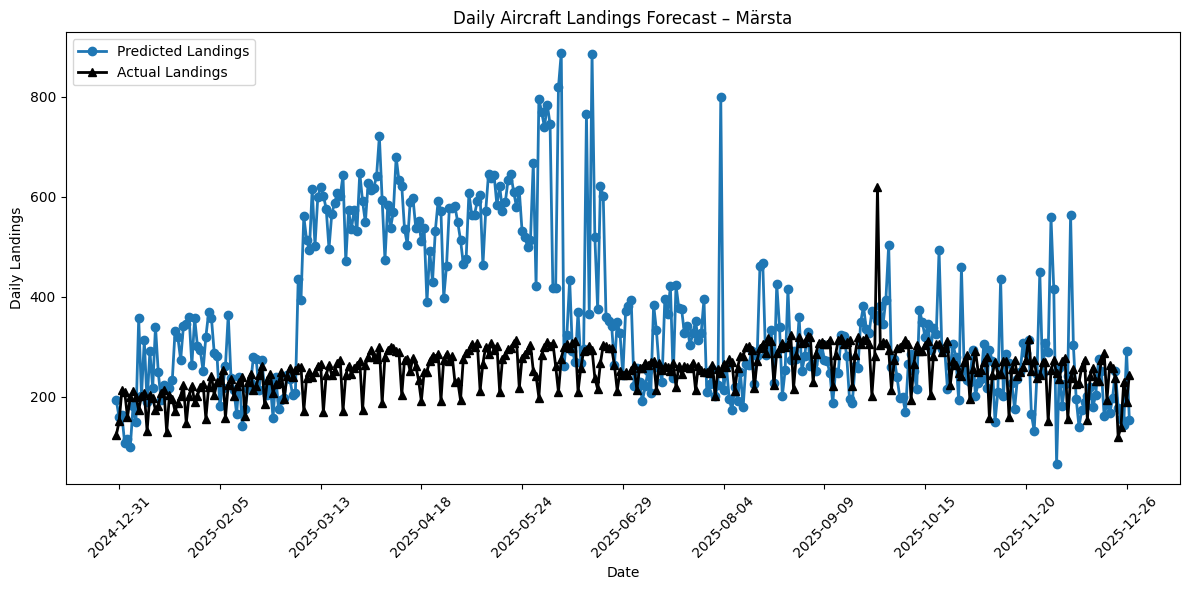

In [24]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import MultipleLocator
import pandas as pd

def plot_landing_forecast(city: str,
                          df: pd.DataFrame,
                          file_path: str,
                          hindcast=False):

    fig, ax1 = plt.subplots(figsize=(12, 6))

    day = pd.to_datetime(df['date'])

    # ---- Main axis: landings ----
    ax1.plot(day, df['predicted_landings'],
             label='Predicted Landings',
             color='tab:blue', linewidth=2, marker='o')

    if hindcast:
        ax1.plot(day, df['total_landings'],
                 label='Actual Landings',
                 color='black', linewidth=2, marker='^')

    ax1.set_ylabel('Daily Landings')
    ax1.set_xlabel('Date')
    ax1.set_title(f"Daily Aircraft Landings Forecast – {city}")
    ax1.legend(loc='upper left')

    # ---- X-axis density control ----
    if len(df) > 12:
        ax1.xaxis.set_major_locator(MultipleLocator(len(df) // 10))

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(file_path)
    return plt
    
plot_landing_forecast("Märsta", df, "flight_weather_model/images", hindcast=True) 



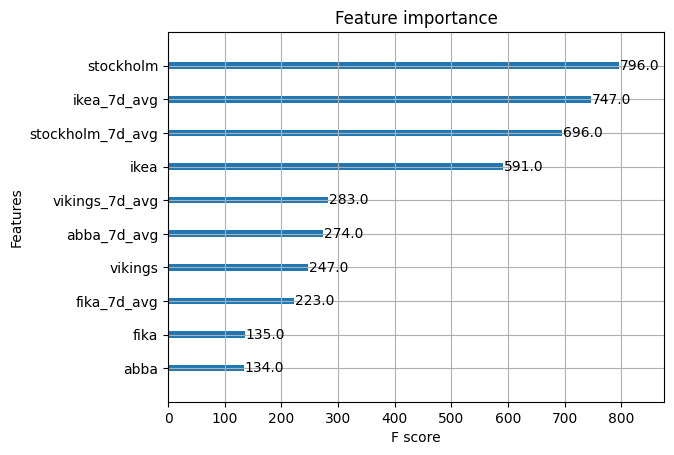

In [25]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor)
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()